In [1]:
img_name = '000000006251.jpg'
img_path = f'/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/images/train/{img_name}'

In [2]:
from src.modules.human_detector.human_detector import HumanDetector

detector = HumanDetector(
    config_path='./src/modules/human_detector/config/faster_rcnn.py',
    pretrained_path="https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/"\
        "faster_rcnn_r101_caffe_fpn_1x_coco/faster_rcnn_r101_caffe_fpn_1x_coco_bbox_mAP-0.398_20200504_180057-b269e9dd.pth",
    checkpoint_path="mmengine_workdir/human_detector/epoch_1.pth",
    data_root_path='/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/',
    device='cpu',
    working_directory='./mmengine_workdir/human_detector',
    log_level='CRITICAL'
)

detector.load_pretrained()
bbox = detector.get_bbox(img_path)
print(bbox)

Loads checkpoint by local backend from path: mmengine_workdir/human_detector/epoch_1.pth
tensor([[ 369.6934,  215.7939, 1149.4197, 1009.2125]])


In [3]:
from src.modules.pose_estimator_2d.pose_estimator_2d import PoseEstimator2D

pose_estimator_2d = PoseEstimator2D(
    config_path='src/modules/pose_estimator_2d/config/hrnet.py',
    pretrained_path='https://download.openmmlab.com/mmpose/v1' \
        '/body_2d_keypoint/topdown_heatmap/coco'\
            '/td-hm_hrnet-w32_8xb64-210e_coco-256x192-81c58e40_20220909.pth',
    checkpoint_path="mmengine_workdir/pose_estimator_2d/best_coco_AP_epoch_0.pth",
    data_root_path='/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/',
    device='cuda:0',
    working_directory='mmengine_workdir/pose_estimator_2d',
    log_level='CRITICAL'
)

pose_estimator_2d.load_pretrained()
pose_estimator_2d_result = pose_estimator_2d.inference(img_path, bbox.detach().cpu().numpy(), bbox_format='xywh')
keypoints_2D = pose_estimator_2d_result[0].pred_instances['keypoints'][0]
print(keypoints_2D)

Loads checkpoint by local backend from path: mmengine_workdir/pose_estimator_2d/best_coco_AP_epoch_0.pth
[[ 592.69273504  338.75680876]
 [ 622.62554042  323.79040575]
 [ 562.75992966  308.82400274]
 [ 622.62554042  368.68961477]
 [ 502.8943189   353.72321177]
 [ 607.65913773  533.32004786]
 [ 443.02870814  533.32004786]
 [ 697.45755386  697.95048094]
 [ 368.19669469  712.91688395]
 [ 817.18877538  533.32004786]
 [ 697.45755386  638.08486891]
 [ 592.69273504  907.48012304]
 [ 472.96151352  982.31213808]
 [1011.75201035  907.48012304]
 [ 951.88639959 1012.2449441 ]
 [1131.48323186 1191.84178019]
 [1026.71841304 1326.53940725]]


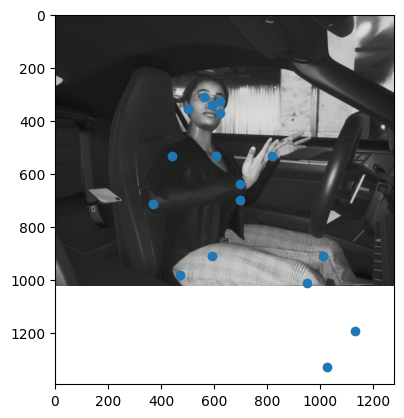

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

keypoints = pd.DataFrame(keypoints_2D, columns=['x', 'y'])

img = mpimg.imread(img_path)
imgplot = plt.imshow(img)
plt.scatter(keypoints['x'], keypoints['y'])
plt.show()

In [5]:
import json
import numpy as np
with open('/root/data/processed/synthetic_cabin_bw/A_Pillar_Codriver/annotations/person_keypoints_train.json') as f:
    data = json.loads(f.readline())

annotations = {}
for id in range(len(data['images'])):
    annotations[data['images'][id]['file_name']] = {
        'keypoints': np.array(data['annotations'][id]['keypoints']).reshape(-1, 3)[:, :2]
    }

/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:680: UserWarning: Warning: The circle is out of bounds, the drawn circle may not be in the image
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:505: UserWarning: Warning: The text is out of bounds, the drawn text may not be in the image
  warnings.warn(


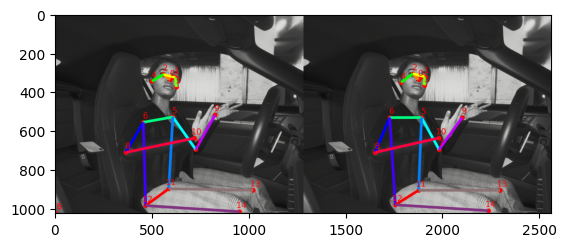

In [6]:
pose_estimator_2d.visualize(
    img_path=img_path,
    bboxes=bbox.tolist(),
    bbox_format='xywh',
    gt_keypoints=np.expand_dims(annotations[img_name]['keypoints'], 0)
)